# AS - TME6
2018-2019

Binome : Stieban Fernandez, Juliette Ortholand

---

## Librairies utiles

In [2]:
import sys
sys.path.insert(0, "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages")

In [2]:
import logging
import torchtext
import torchtext.datasets as datasets
import torchtext.data as data
import torch.nn as nn
import torch

from torchvision import transforms
import torchvision.datasets as datasets_vision

import tensorboard
import tensorboardX
import tensorflow
import spacy
import nltk

from tqdm import tqdm

C:\Users\Steban\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Convolutional Neural Network

In [3]:
class ConvNet1(nn.Module):
    """ Simple CNN 1D for analysis """
    
    def __init__(self, channels_size):
        super(ConvNet1, self).__init__()
        
        self.conv = nn.Conv1d(channels_size, 3, kernel_size=3, stride=1)
        self.tret = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.clas = nn.Linear(3, 3)
        
    def forward(self, X):
        out = self.conv(X)
        out = self.tret(out)
        out = self.clas(out.squeeze())
        return out

In [3]:
class ConvNet2(nn.Module):
    """ Simple CNN 2D for analysis """
    
    def __init__(self, channels_size, output_size):
        super(ConvNet2, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(channels_size, 3, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3)
        )
        self.clas = nn.Linear(24, output_size)
        
    def forward(self, X):
        out = self.conv(X)
        out = out.mean(len(out.shape)-1).view(X.shape[0], -1)
        out = self.clas(out)
        return out

In [6]:
class ConvNet3(nn.Module):
    """ More complex than ConvNet2 """
    
    def __init__(self, channels_size, output_size):
        super(ConvNet3, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(channels_size, 24, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(24, 14, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(28)
        )
        self.clas = nn.Sequential(
            nn.Linear(24*28*28, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
        
    def forward(self, X):
        out = self.conv(X)
        out = self.clas(out.view(X.shape[0], -1))
        return out

---

## Sentiment Analysis

### Préparation des données

In [6]:
#DATA_DIR="/users/Enseignants/baskiotis/AS"
DATA_DIR="C:\\Users\\Steban\\Documents\\Cours\\M2\\AS\\data"

DATASET_DIR="%s/datasets" % DATA_DIR
VECTORS_DIR="%s/vectors" % DATA_DIR

# text
TEXT=data.Field(lower=True,include_lengths=False,batch_first=True)
LABEL = data.Field(sequential=False, is_target=True)

# make splits for data
train, val, test = datasets.sst.SST.splits(TEXT, LABEL,root=DATASET_DIR)

# Use the vocabulary
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train, vectors=wordemb)
LABEL.build_vocab(train, specials_first=False)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(train, val, test), batch_size=1000, device=0)

nn_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [7]:
print(TEXT.vocab.vectors.shape)
print(nn_embeddings)

torch.Size([16583, 100])
Embedding(16583, 100)


### Analyse

Apprentissage

In [8]:
def fit_eval(model, train_iter, val_iter, loss=nn.CrossEntropyLoss(), n_epochs=20, lr=1e-3):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    val_loss = []

    train_score = []
    val_score = []
    
    # Fit / Eval
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for batch in train_iter:
            t = batch.text # batch_size phrases de max nb mots (taille variable), reste du vecteur complété par 1
            l = batch.label # vecteur de 10 
            x = nn_embeddings(t).transpose(1,2) # shape : (batch_size, input_channels, nb_mots_max)

            out = model(x)
            cost = loss(out, l) 
            optim.zero_grad()
            cost.backward()
            optim.step()
            costs_train.append(cost)
            scores_train.append(score(out, l))
        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        ####### VALID #######
        costs_val = []
        scores_val = []
        for batch in val_iter:
            t = batch.text 
            l = batch.label 
            x = nn_embeddings(t).transpose(1,2)

            out = model(x)
            cost = loss(out, l)
            costs_val.append(cost)
            scores_val.append(score(out,l))
        val_score.append(torch.tensor(scores_val).mean())
        val_loss.append(torch.tensor(costs_val).mean())
    
    return train_loss, val_loss, train_score, val_score

Score

In [9]:
def score(_input, target):
    """ Calculate core """
    return (_input.argmax(1) == target).float().mean()

Affichage

In [10]:
import matplotlib.pyplot as plt

def plot_loss_score(train_loss, val_loss, train_score, val_score):
    # Loss
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, c="red", label="train")
    plt.plot(val_loss, c="b", label="val")
    plt.legend(loc="best")
    plt.show()
    
    # Score
    plt.figure(figsize=(10,7))
    plt.plot(train_score, c="red", label="train")
    plt.plot(val_score, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

Essai 1 : Sentiment Analysis

100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


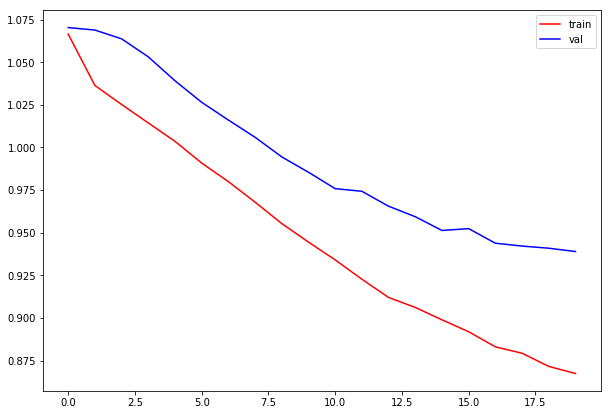

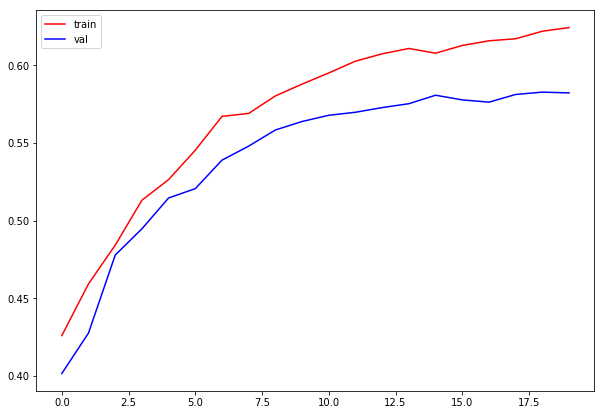

In [83]:
model = ConvNet1(100)

res = fit_eval(model, train_iter, val_iter)
plot_loss_score(*res)

100%|██████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


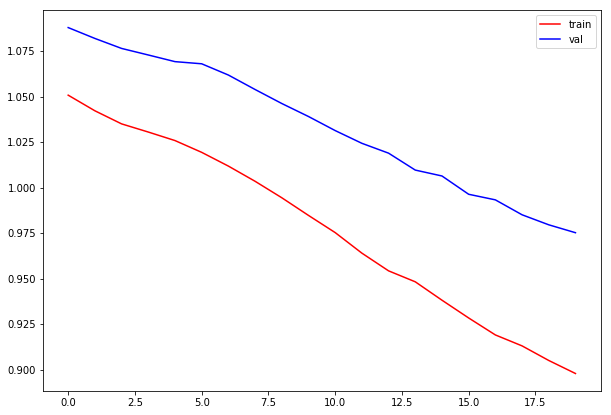

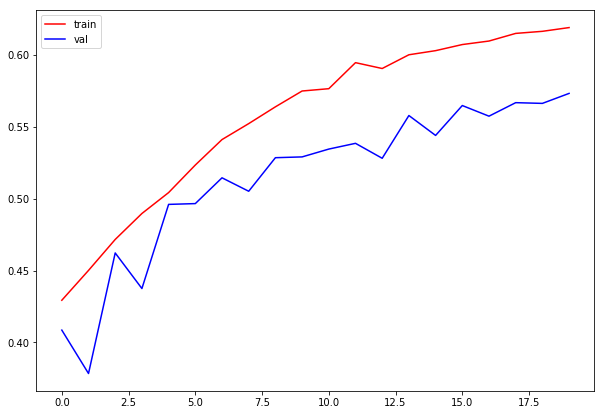

In [12]:
model = ConvNet1(100)

res = fit_eval(model, train_iter, val_iter)
plot_loss_score(*res)

Que se passe-t-il dans un CNN ?
- Etude des filtres

Travail en batch :

Chaque vecteur correspond à un filtre. Remonter l'information de position, savoir à quelle portion de l'entrée le vecteur fait référence.

- Pour chaque phrase, pour chaque composante, voir le max
- Quels sont les bouts de séquence qui activent le plus de filtre ?
- $ (w_i, s_i) \rightarrow (w, s) \rightarrow (w_0, s_0) $ : voir le stride
- La j ième sortie correspond à $ (j_{s_0}) ...  (j_{s_0} + w_0 - 1) $

Qu'est ce qui explique ma classification ?

Quelles sont les parties de ma phrase qui définissent ce qui est positif, négatif ?

Procédure :

Conv -> MaxPooling (1 vecteur en sortie) -> Softmax

ex : Comment varie l'embedding par rapport à la sortie ?
- Gradient de la sortie correspondante dans le module linéaire au niveau de Softmax par rapport à l'entrée x
- Si on s'aperçoit que les dérivées sont fortes $ \rightarrow $ importance
- Norme du gradient de X par rapport au j ième vecteur (ne pas oublier requires_grad=True)

Poids de la couche de convolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


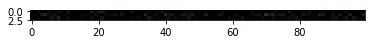

In [84]:
plt.imshow(model.conv.weight.detach().numpy())

 ### Phrases qui activent le plus le filtre

In [13]:
import copy
import numpy as np

def extract_sentences(out, batch, TEXT, k, f):
    """ 
        :out: sortie de la convolution
        :batch: phrases en mots du batch
        :TEXT: Structure des données textuelles
        :k: nombre de phrases
        :f: filtre à étudier
    """
    
    out_mean = copy.copy(out).detach().numpy()
    out_test = out_mean[:,f]
    out_test = np.amax(out_test, axis=1)
    print(out_test.shape)
    list_sentences = []
    plt.imshow(out_mean[:20,f])
    plt.show()
    for i in range(k):
        m = out_test.argmax()
        print(out_mean[m,f].argmax())
        sentence = TEXT.reverse(t[m:m+1].data)
        list_sentences.append(sentence)
        plt.imshow(out_mean[m,f:f+1])
        plt.show()
        print(sentence)
        out_test[m] = -1
        
    return list_sentences

In [ ]:
...

---

## 2. MNIST

### Préparation des données

In [4]:
batch_size=32
nb_digits=10

train_loader = torch.utils.data.DataLoader(
    datasets_vision.MNIST('../data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])), batch_size=batch_size, shuffle=True) 

test_loader = torch.utils.data.DataLoader(
    datasets_vision.MNIST('../data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])), batch_size=batch_size)

Dimensions

In [5]:
for i, (x, y) in enumerate(train_loader):
    ex, label = x, y
    break

print(ex.shape, label.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Affichage des chiffres

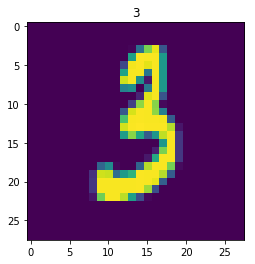

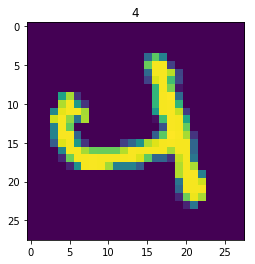

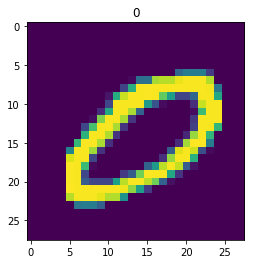

In [17]:
for i in range(3):
    plt.title(label[i].item())
    plt.imshow(ex[i][0])
    plt.show()

### Analyse

Apprentissage

In [6]:
def fit_eval2(model, train_iter, val_iter, loss=nn.CrossEntropyLoss(), n_epochs=20, lr=1e-3):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    val_loss = []

    train_score = []
    val_score = []
    
    # Fit / Eval
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:
            out = model(x)
            cost = loss(out, l)
            optim.zero_grad()
            cost.backward()
            optim.step()
            costs_train.append(cost)
            scores_train.append(score(out, l))
        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            out = model(x)
            cost = loss(out, l)
            costs_val.append(cost)
            scores_val.append(score(out,l))
        val_score.append(torch.tensor(scores_val).mean())
        val_loss.append(torch.tensor(costs_val).mean())
    
    return train_loss, val_loss, train_score, val_score

Essai 1 : MNIST ConvNet1

100%|██████████████████████████████████████████| 20/20 [05:43<00:00, 15.72s/it]


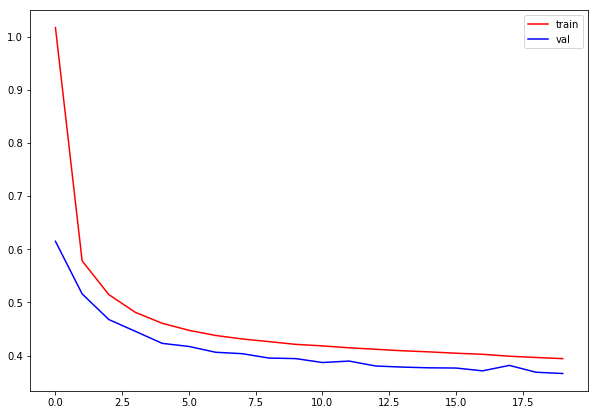

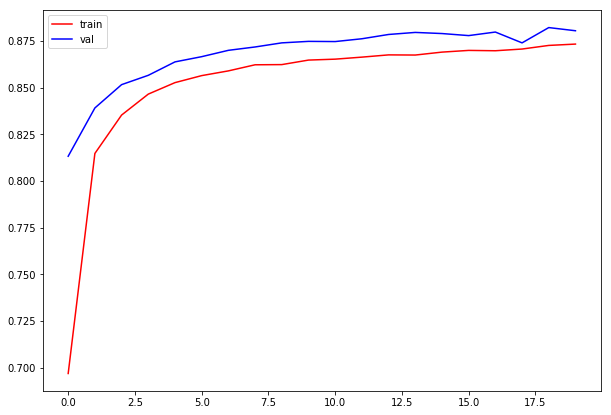

In [13]:
model = ConvNet2(1, 10)

res = fit_eval2(model, train_loader, test_loader)
plot_loss_score(*res)

Visualisation poids

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


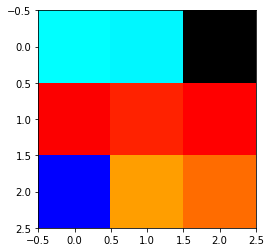

In [14]:
plt.imshow(model.conv[0].weight.detach().numpy().reshape(3,3,3))

Essai 2 : MNIST ConvNet2

In [ ]:
## A NE PAS LANCER, FAIT PLANTER
model = ConvNet3(1, 10)

res = fit_eval2(model, train_loader, test_loader)
plot_loss_score(*res)

 35%|███▌      | 7/20 [18:36<39:23, 181.81s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-7f8616aa9fdb>", line 3, in <module>
    res = fit_eval2(model, train_loader, test_loader)
  File "<ipython-input-10-7372714b6886>", line 16, in fit_eval2
    for x, l in train_iter:
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 314, in __next__
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 314, in <listcomp>
    batch = self.collate_fn([self.dataset[i] for i in indices]

Exception ignored in: <bound method tqdm.__del__ of  35%|███▌      | 7/20 [20:36<39:23, 181.81s/it]>
Traceback (most recent call last):
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.5/threading.py", line 1051, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


Problème de ressources